In [1]:
# Import packages
from urllib.request import urlopen
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
import math
from io import StringIO

In [2]:
def get_elec_sub_90(start_date, end_date):
    # Format URL
    DNO = "12" # London area.
    VOLTAGE = "LV" # Low voltage.
    start_date = start_date.strftime("%d-%m-%Y")
    end_date = end_date.strftime("%d-%m-%Y")
    url = f"https://odegdcpnma.execute-api.eu-west-2.amazonaws.com/development/prices?dno={DNO}&voltage={VOLTAGE}&start={start_date}&end={end_date}"
    
    # Hit the API to get the JSON.
    response = urlopen(url)
    data_json = json.loads(response.read())
    
    # Format as a dataframe.
    df = pd.json_normalize(data_json["data"]["data"])
    df = df.drop(columns="unixTimestamp")
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%H:%M %d-%m-%Y")
    df.set_index("Timestamp", inplace=True)
    
    return df

In [3]:
def get_electricity(start_date="01-10-2022", end_date="01-01-2023", groupBy='M'):
    """Get the weekly electricity as a pandas dataframe. 
    
    start_date: Format "DD-MM-YYYY". Start date.
    end_date: Format "DD-MM-YYYY". End date.
    groupBy: Format 'Y', 'M', or 'D'. Group by year, month or day."""
    
    # Set constants.
    DAY_LIMIT = 90
    
    # Work out if date is over 90 days.
    date_format = "%d-%m-%Y"
    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)
    delta = (end - start).days

    # Split starts and ends into separate dates.
    if delta > DAY_LIMIT:
        nRuns = math.ceil(delta / DAY_LIMIT)
        output_dfs = []
        for iRun in range(nRuns):  
            this_start = start + timedelta(days=(iRun * DAY_LIMIT))
            this_end = this_start + timedelta(days=DAY_LIMIT)
            output_dfs.append(get_elec_sub_90(this_start, this_end))

        # Concatenate dfs.
        elec_prices = pd.concat(output_dfs)
        
    else:
        elec_prices = get_elec_sub_90(start_date, end_date)
        
    # Get mean of each week, month, or day.
    elec_monthly = elec_prices.resample(groupBy).mean()

    return elec_monthly

In [4]:
def calculate_future_spending(monthly_spending_list, predicted_prices_df):
    """Calculate spending for the next N months based on the last bill"""
    # Get last bill value from list.
    last_bill = monthly_spending_list[-1]

    # Current date.
    current_month = datetime.now().date()

    # Filter previous months.
    future_elec = predicted_prices_df.loc[current_month - timedelta(days=32) : ]

    # Calculate percentage difference.
    diff_factor = future_elec['Overall'].pct_change()

    # Calculate future spending.
    future_spending = (1 + diff_factor) * last_bill
    future_spending = future_spending.drop(index=future_spending.index[0])
    future_spending_df = pd.DataFrame(future_spending)

    # Get past timestamps.
    past_elec_prices = predicted_prices_df.loc[: current_month]
    past_timestamps = past_elec_prices.index.values
    past_spending = pd.DataFrame({"Timestamp": past_timestamps, "Overall": monthly_spending_list})
    past_spending["Timestamp"] = pd.to_datetime(past_spending["Timestamp"], format="%d-%m-%Y")
    past_spending.set_index("Timestamp", inplace=True)

    # Combine current and future spending.
    total_spending = pd.concat([past_spending, future_spending_df])
    
    return total_spending

In [5]:
def get_graph(df):
    """Plot a graph from a DataFrame"""
    # fig = plt.figure()
    # plt.bar(range(len(df)), df)
    fig = df.plot(kind="bar", ylim=(90,120))
    fig.set_xlabel("Date")
    fig.set_ylabel("Spending (£)")
    fig.set_title("Current and Future Electricity Spending")
    fig.axvline(2.5)    
    fig.set_xticklabels([x.strftime("%Y-%m") for x in df.index], rotation=45)
    
    imgdata = StringIO()
    fig.figure.savefig(imgdata, format="svg")
    imgdata.seek(0)

    data = imgdata.getvalue()
    return data

In [6]:
# Plot total spending graph.
def get_future_elec():
    # Call the function.
    START_DATE = "01-07-2022"
    END_DATE = "01-12-2022"
    GROUP_BY = "M"
    elec_by_month = get_electricity(START_DATE, END_DATE, GROUP_BY)
    
    # Calculate difference in spending on electricity.
    SPENDING_ON_ELEC = [100, 98, 110]
    total_spend = calculate_future_spending(SPENDING_ON_ELEC, elec_by_month)
    
    figure = get_graph(total_spend)

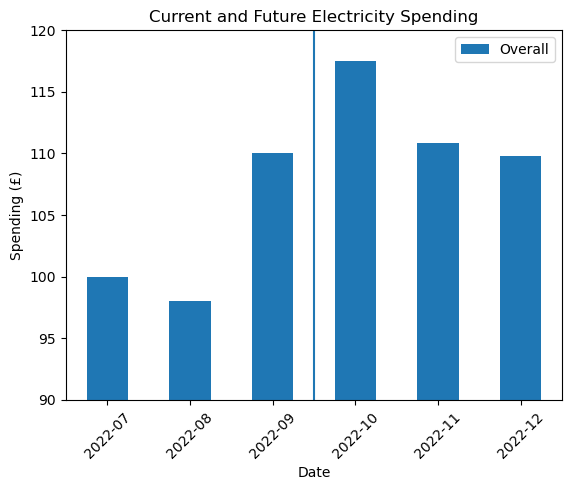

In [7]:
# Run everything.
get_future_elec()

In [8]:
##############################################################################################################

In [9]:
# Format URL
DNO = "12" # London area.
VOLTAGE = "LV" # Low voltage.
START_DATE = "01-09-2022"
END_DATE = "01-01-2023"

url = f"https://odegdcpnma.execute-api.eu-west-2.amazonaws.com/development/prices?dno={DNO}&voltage={VOLTAGE}&start={START_DATE}&end={END_DATE}"

In [10]:
# Hit the API to get the JSON.
response = urlopen(url)
data_json = json.loads(response.read())
print(json.dumps(data_json, indent=2)[0:300])

{
  "errorMessage": "2022-10-15T18:46:08.919Z 4172a7fe-8ea3-411a-bce7-a8bd79e8f177 Task timed out after 10.04 seconds"
}


In [11]:
# Show the response.
df = pd.json_normalize(data_json["data"]["data"])
df = df.drop(columns="unixTimestamp")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%H:%M %d-%m-%Y")
df.set_index("Timestamp", inplace=True)
df

KeyError: 'data'

In [ ]:
# Plot the response.
x = "Date/Time"
y = "Price (£/kWh)"
ax = df["Overall"].plot(x=x, y=y)
plt.show()

In [ ]:
# Get mean of each week.
df_weekly = df.resample('M').mean()
df_weekly

In [ ]:
# Plot the response.
x = "Date"
y = "Price (£/kWh)"
ax = df_weekly["Overall"].plot(x=x, y=y)
plt.show()

In [ ]:
# Calculate difference in spending on electricity.
SPENDING_ON_ELEC = [100, 98, 110]

# Get last bill value from list.
last_bill = SPENDING_ON_ELEC[-1]

# Current date.
current_month = datetime.now().date()

# Filter previous months.
future_elec = elec_by_month.loc[current_month - timedelta(days=32) : ]

# Calculate percentage difference.
diff_factor = future_elec['Overall'].pct_change()

# Calculate future spending.
future_spending = (1 + diff_factor) * last_bill
future_spending = future_spending.drop(index=future_spending.index[0])
future_spending_df = pd.DataFrame(future_spending)

# Get past timestamps.
past_elec_prices = elec_by_month.loc[: current_month]
past_timestamps = past_elec_prices.index.values
past_spending = pd.DataFrame({"Timestamp": past_timestamps, "Overall": SPENDING_ON_ELEC})
past_spending["Timestamp"] = pd.to_datetime(past_spending["Timestamp"], format="%d-%m-%Y")
past_spending.set_index("Timestamp", inplace=True)

# Combine current and future spending.
total_spending = pd.concat([past_spending, future_spending_df])
total_spending